# Federated Learning with Pytorch Backend

>The following codes are demos only. It's **NOT for production** due to system security concerns, please **DO NOT** use it directly in production.

In this tutorial, We will walk you through how to use pytorch backend on SecretFlow for federated learning.  

+ We will use the image clasification task as example
+ Use pytorch as backend
+ We will show how to use multi fl strategy
  
If you want to learn more about federated learning, datasets, etc., you can move to [Federated Learning for Image Classification](Federate_Learning_for_Image_Classification.ipynb).
  
**Here we go!**

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import secretflow as sf

# Check the version of your SecretFlow
print('The version of SecretFlow: {}'.format(sf.__version__))

# In case you have a running secretflow runtime already.
sf.shutdown()

sf.init(['alice', 'bob', 'charlie'], address='local')
alice, bob, charlie = sf.PYU('alice'), sf.PYU('bob'), sf.PYU('charlie')

The version of SecretFlow: 1.4.0.dev20240105


2024-01-09 13:49:01,807	INFO worker.py:1538 -- Started a local Ray instance.


### Here, let us first introduce some concepts
BaseModule: Similar to the `torch.nn.module`.    
TorchModel: A wrap class include `loss_fn`,`optim_fn`,`model_def`,`metrics`.  
metric_wrapper: Wrap metrics to workers.  
optim_wrapper: Wrap optim_fn to workers.  
FLModel: Federated model, use `backend` to specify which bachend will be use, use `strategy` to spcify which federated strategy will be use.

In [3]:
from secretflow.ml.nn.utils import BaseModule, TorchModel
from secretflow.ml.nn.fl.utils import metric_wrapper, optim_wrapper
from secretflow.ml.nn import FLModel
from torchmetrics import Accuracy, Precision
from secretflow.security.aggregation import SecureAggregator
from secretflow.utils.simulation.datasets import load_mnist
from torch import nn, optim
from torch.nn import functional as F

2024-01-09 13:49:40.811033: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-09 13:49:42.241506: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-01-09 13:49:42.241632: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-01-09 13:49:42.241638: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed proper

When we define the model, we only need to inherit `BaseModule` instead of `nn.Module`, and the others are consistent with pytorch.

In [4]:
class ConvNet(BaseModule):
    """Small ConvNet for MNIST."""

    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, kernel_size=3)
        self.fc_in_dim = 192
        self.fc = nn.Linear(self.fc_in_dim, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 3))
        x = x.view(-1, self.fc_in_dim)
        x = self.fc(x)
        return F.softmax(x, dim=1)

We can continue to use the loss function and optimizer defined in pytorch, the only difference is that we need to wrap it with the wrapper provided in secretflow.

In [5]:
(train_data, train_label), (test_data, test_label) = load_mnist(
    parts={alice: 0.4, bob: 0.6},
    normalized_x=True,
    categorical_y=True,
    is_torch=True,
)

loss_fn = nn.CrossEntropyLoss
optim_fn = optim_wrapper(optim.Adam, lr=1e-2)
model_def = TorchModel(
    model_fn=ConvNet,
    loss_fn=loss_fn,
    optim_fn=optim_fn,
    metrics=[
        metric_wrapper(Accuracy, task="multiclass", num_classes=10, average='micro'),
        metric_wrapper(Precision, task="multiclass", num_classes=10, average='micro'),
    ],
)

In [6]:
device_list = [alice, bob]
server = charlie
aggregator = SecureAggregator(server, [alice, bob])

# spcify params
fl_model = FLModel(
    server=server,
    device_list=device_list,
    model=model_def,
    aggregator=aggregator,
    strategy='fed_avg_w',  # fl strategy
    backend="torch",  # backend support ['tensorflow', 'torch']
)

INFO:root:Create proxy actor <class 'secretflow.security.aggregation.secure_aggregator._Masker'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.security.aggregation.secure_aggregator._Masker'> with party bob.
INFO:root:Create proxy actor <class 'secretflow.ml.nn.fl.backend.torch.strategy.fed_avg_w.PYUFedAvgW'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.ml.nn.fl.backend.torch.strategy.fed_avg_w.PYUFedAvgW'> with party bob.


In [7]:
history = fl_model.fit(
    train_data,
    train_label,
    validation_data=(test_data, test_label),
    epochs=20,
    batch_size=32,
    aggregate_freq=1,
)

INFO:root:FL Train Params: {'x': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7fb076a1f550>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7fb076a1f910>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'y': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7fb0769e0310>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7fb0769e0760>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'batch_size': 32, 'batch_sampling_rate': None, 'epochs': 20, 'verbose': 1, 'callbacks': None, 'validation_data': (FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7fb0769e0880>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7fb0769e0b80>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7fb0

Epoch 1/20


Train Processing: :  96%|█████████▋| 722/750 [00:26<00:00, 30.38it/s](raylet) [2024-01-09 13:52:01,747 E 25563 25563] (raylet) node_manager.cc:3097: 6 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: d479e7b188ac726f4e8606e6559d5d5b8381b3364887775d73118d2b, IP: 10.0.0.1) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 10.0.0.1`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
Train Processing: :  99%|█████████▉| 746/750 [00:27<00:0

Epoch 2/20
(PYUFedAvgW pid=32498) {'train-loss': 1.5026354789733887, 'train_multiclassaccuracy': tensor(0.0129), 'train_multiclassprecision': tensor(0.0129), 'val_eval_multiclassaccuracy': tensor(0.0261), 'val_eval_multiclassprecision': tensor(0.0261)}
(PYUFedAvgW pid=32495) {'train-loss': 1.5381978750228882, 'train_multiclassaccuracy': tensor(0.0129), 'train_multiclassprecision': tensor(0.0129), 'val_eval_multiclassaccuracy': tensor(0.0168), 'val_eval_multiclassprecision': tensor(0.0168)}


Train Processing: :   0%|          | 3/750 [00:00<00:31, 24.03it/s]

Epoch 3/20
(PYUFedAvgW pid=32498) {'train-loss': 1.499314308166504, 'train_multiclassaccuracy': tensor(0.0251), 'train_multiclassprecision': tensor(0.0251), 'val_eval_multiclassaccuracy': tensor(0.0310), 'val_eval_multiclassprecision': tensor(0.0310)}
(PYUFedAvgW pid=32495) {'train-loss': 1.5248055458068848, 'train_multiclassaccuracy': tensor(0.0255), 'train_multiclassprecision': tensor(0.0255), 'val_eval_multiclassaccuracy': tensor(0.0202), 'val_eval_multiclassprecision': tensor(0.0202)}


Train Processing: :  23%|██▎       | 171/750 [00:05<00:17, 32.48it/s](raylet) [2024-01-09 13:53:01,749 E 25563 25563] (raylet) node_manager.cc:3097: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: d479e7b188ac726f4e8606e6559d5d5b8381b3364887775d73118d2b, IP: 10.0.0.1) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 10.0.0.1`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
Train Processing: :   0%|          | 3/750 [00:00<00:29,

Epoch 4/20
(PYUFedAvgW pid=32498) {'train-loss': 1.4700618982315063, 'train_multiclassaccuracy': tensor(0.0327), 'train_multiclassprecision': tensor(0.0327), 'val_eval_multiclassaccuracy': tensor(0.0386), 'val_eval_multiclassprecision': tensor(0.0386)}
(PYUFedAvgW pid=32495) {'train-loss': 1.5233030319213867, 'train_multiclassaccuracy': tensor(0.0331), 'train_multiclassprecision': tensor(0.0331), 'val_eval_multiclassaccuracy': tensor(0.0287), 'val_eval_multiclassprecision': tensor(0.0287)}


Train Processing: :   3%|▎         | 23/750 [00:00<00:20, 34.86it/s](raylet) [2024-01-09 13:54:01,751 E 25563 25563] (raylet) node_manager.cc:3097: 9 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: d479e7b188ac726f4e8606e6559d5d5b8381b3364887775d73118d2b, IP: 10.0.0.1) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 10.0.0.1`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
Train Processing: :   0%|          | 3/750 [00:00<00:31, 

Epoch 5/20
(PYUFedAvgW pid=32498) {'train-loss': 1.463574767112732, 'train_multiclassaccuracy': tensor(0.0398), 'train_multiclassprecision': tensor(0.0398), 'val_eval_multiclassaccuracy': tensor(0.0479), 'val_eval_multiclassprecision': tensor(0.0479)}
(PYUFedAvgW pid=32495) {'train-loss': 1.5122534036636353, 'train_multiclassaccuracy': tensor(0.0403), 'train_multiclassprecision': tensor(0.0403), 'val_eval_multiclassaccuracy': tensor(0.0377), 'val_eval_multiclassprecision': tensor(0.0377)}


Train Processing: :   0%|          | 3/750 [00:00<00:32, 22.88it/s]

Epoch 6/20
(PYUFedAvgW pid=32498) {'train-loss': 1.4665617942810059, 'train_multiclassaccuracy': tensor(0.0444), 'train_multiclassprecision': tensor(0.0444), 'val_eval_multiclassaccuracy': tensor(0.0522), 'val_eval_multiclassprecision': tensor(0.0522)}
(PYUFedAvgW pid=32495) {'train-loss': 1.4984899759292603, 'train_multiclassaccuracy': tensor(0.0448), 'train_multiclassprecision': tensor(0.0448), 'val_eval_multiclassaccuracy': tensor(0.0423), 'val_eval_multiclassprecision': tensor(0.0423)}


Train Processing: :   0%|          | 3/750 [00:00<00:27, 26.93it/s]

Epoch 7/20
(PYUFedAvgW pid=32498) {'train-loss': 1.4646514654159546, 'train_multiclassaccuracy': tensor(0.0488), 'train_multiclassprecision': tensor(0.0488), 'val_eval_multiclassaccuracy': tensor(0.0578), 'val_eval_multiclassprecision': tensor(0.0578)}
(PYUFedAvgW pid=32495) {'train-loss': 1.4911092519760132, 'train_multiclassaccuracy': tensor(0.0494), 'train_multiclassprecision': tensor(0.0494), 'val_eval_multiclassaccuracy': tensor(0.0465), 'val_eval_multiclassprecision': tensor(0.0465)}


Train Processing: : 100%|█████████▉| 749/750 [00:53<00:00, 13.95it/s, {'multiclassaccuracy': 0.053397223, 'multiclassprecision': 0.053397223, 'val_multiclassaccuracy': 0.057466667, 'val_multiclassprecision': 0.057466667}]


(PYUFedAvgW pid=32495) {'train-loss': 1.4858157634735107, 'train_multiclassaccuracy': tensor(0.0536), 'train_multiclassprecision': tensor(0.0536), 'val_eval_multiclassaccuracy': tensor(0.0520), 'val_eval_multiclassprecision': tensor(0.0520)}
(PYUFedAvgW pid=32498) {'train-loss': 1.4620774984359741, 'train_multiclassaccuracy': tensor(0.0532), 'train_multiclassprecision': tensor(0.0532), 'val_eval_multiclassaccuracy': tensor(0.0629), 'val_eval_multiclassprecision': tensor(0.0629)}


Train Processing: :   0%|          | 3/750 [00:00<00:31, 24.07it/s]

Epoch 8/20


Train Processing: :   0%|          | 3/750 [00:00<00:30, 24.22it/s]

Epoch 9/20
(PYUFedAvgW pid=32498) {'train-loss': 1.4617977142333984, 'train_multiclassaccuracy': tensor(0.0596), 'train_multiclassprecision': tensor(0.0596), 'val_eval_multiclassaccuracy': tensor(0.0701), 'val_eval_multiclassprecision': tensor(0.0701)}
(PYUFedAvgW pid=32495) {'train-loss': 1.483565092086792, 'train_multiclassaccuracy': tensor(0.0594), 'train_multiclassprecision': tensor(0.0594), 'val_eval_multiclassaccuracy': tensor(0.0610), 'val_eval_multiclassprecision': tensor(0.0610)}


Train Processing: :   0%|          | 3/750 [00:00<00:30, 24.60it/s]

Epoch 10/20
(PYUFedAvgW pid=32498) {'train-loss': 1.463520884513855, 'train_multiclassaccuracy': tensor(0.0654), 'train_multiclassprecision': tensor(0.0654), 'val_eval_multiclassaccuracy': tensor(0.0730), 'val_eval_multiclassprecision': tensor(0.0730)}
(PYUFedAvgW pid=32495) {'train-loss': 1.4812475442886353, 'train_multiclassaccuracy': tensor(0.0653), 'train_multiclassprecision': tensor(0.0653), 'val_eval_multiclassaccuracy': tensor(0.0633), 'val_eval_multiclassprecision': tensor(0.0633)}


Train Processing: : 100%|█████████▉| 749/750 [01:05<00:00, 11.39it/s, {'multiclassaccuracy': 0.06946042, 'multiclassprecision': 0.06946042, 'val_multiclassaccuracy': 0.07415833, 'val_multiclassprecision': 0.07415833}]


(PYUFedAvgW pid=32498) {'train-loss': 1.4615941047668457, 'train_multiclassaccuracy': tensor(0.0695), 'train_multiclassprecision': tensor(0.0695), 'val_eval_multiclassaccuracy': tensor(0.0800), 'val_eval_multiclassprecision': tensor(0.0800)}
(PYUFedAvgW pid=32495) {'train-loss': 1.4624273777008057, 'train_multiclassaccuracy': tensor(0.0694), 'train_multiclassprecision': tensor(0.0694), 'val_eval_multiclassaccuracy': tensor(0.0683), 'val_eval_multiclassprecision': tensor(0.0683)}


Train Processing: :   0%|          | 3/750 [00:00<00:28, 26.12it/s]

Epoch 11/20


Train Processing: :  99%|█████████▉| 746/750 [00:24<00:00, 36.09it/s](raylet) [2024-01-09 14:04:01,779 E 25563 25563] (raylet) node_manager.cc:3097: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: d479e7b188ac726f4e8606e6559d5d5b8381b3364887775d73118d2b, IP: 10.0.0.1) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 10.0.0.1`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
Train Processing: :   0%|          | 3/750 [00:00<00:29,

Epoch 12/20
(PYUFedAvgW pid=32498) {'train-loss': 1.4612447023391724, 'train_multiclassaccuracy': tensor(0.0728), 'train_multiclassprecision': tensor(0.0728), 'val_eval_multiclassaccuracy': tensor(0.0822), 'val_eval_multiclassprecision': tensor(0.0822)}
(PYUFedAvgW pid=32495) {'train-loss': 1.4623854160308838, 'train_multiclassaccuracy': tensor(0.0732), 'train_multiclassprecision': tensor(0.0732), 'val_eval_multiclassaccuracy': tensor(0.0708), 'val_eval_multiclassprecision': tensor(0.0708)}


Train Processing: :   0%|          | 3/750 [00:00<00:28, 26.48it/s]

Epoch 13/20
(PYUFedAvgW pid=32498) {'train-loss': 1.4611862897872925, 'train_multiclassaccuracy': tensor(0.0793), 'train_multiclassprecision': tensor(0.0793), 'val_eval_multiclassaccuracy': tensor(0.0924), 'val_eval_multiclassprecision': tensor(0.0924)}
(PYUFedAvgW pid=32495) {'train-loss': 1.4621374607086182, 'train_multiclassaccuracy': tensor(0.0798), 'train_multiclassprecision': tensor(0.0798), 'val_eval_multiclassaccuracy': tensor(0.0805), 'val_eval_multiclassprecision': tensor(0.0805)}


Train Processing: :   0%|          | 2/750 [00:00<00:40, 18.54it/s]

Epoch 14/20
(PYUFedAvgW pid=32498) {'train-loss': 1.4613405466079712, 'train_multiclassaccuracy': tensor(0.0857), 'train_multiclassprecision': tensor(0.0857), 'val_eval_multiclassaccuracy': tensor(0.0958), 'val_eval_multiclassprecision': tensor(0.0958)}
(PYUFedAvgW pid=32495) {'train-loss': 1.4614176750183105, 'train_multiclassaccuracy': tensor(0.0866), 'train_multiclassprecision': tensor(0.0866), 'val_eval_multiclassaccuracy': tensor(0.0828), 'val_eval_multiclassprecision': tensor(0.0828)}


Train Processing: :   0%|          | 3/750 [00:00<00:30, 24.89it/s]

Epoch 15/20
(PYUFedAvgW pid=32498) {'train-loss': 1.4611986875534058, 'train_multiclassaccuracy': tensor(0.0966), 'train_multiclassprecision': tensor(0.0966), 'val_eval_multiclassaccuracy': tensor(0.1119), 'val_eval_multiclassprecision': tensor(0.1119)}
(PYUFedAvgW pid=32495) {'train-loss': 1.4625885486602783, 'train_multiclassaccuracy': tensor(0.0972), 'train_multiclassprecision': tensor(0.0972), 'val_eval_multiclassaccuracy': tensor(0.0979), 'val_eval_multiclassprecision': tensor(0.0979)}


Train Processing: :   0%|          | 3/750 [00:00<00:30, 24.31it/s]

Epoch 16/20
(PYUFedAvgW pid=32498) {'train-loss': 1.4611600637435913, 'train_multiclassaccuracy': tensor(0.1045), 'train_multiclassprecision': tensor(0.1045), 'val_eval_multiclassaccuracy': tensor(0.1182), 'val_eval_multiclassprecision': tensor(0.1182)}
(PYUFedAvgW pid=32495) {'train-loss': 1.4660673141479492, 'train_multiclassaccuracy': tensor(0.1050), 'train_multiclassprecision': tensor(0.1050), 'val_eval_multiclassaccuracy': tensor(0.1028), 'val_eval_multiclassprecision': tensor(0.1028)}


Train Processing: :   0%|          | 3/750 [00:00<00:26, 28.38it/s]

Epoch 17/20
(PYUFedAvgW pid=32498) {'train-loss': 1.4616273641586304, 'train_multiclassaccuracy': tensor(0.1165), 'train_multiclassprecision': tensor(0.1165), 'val_eval_multiclassaccuracy': tensor(0.1386), 'val_eval_multiclassprecision': tensor(0.1386)}
(PYUFedAvgW pid=32495) {'train-loss': 1.461342215538025, 'train_multiclassaccuracy': tensor(0.1163), 'train_multiclassprecision': tensor(0.1163), 'val_eval_multiclassaccuracy': tensor(0.1215), 'val_eval_multiclassprecision': tensor(0.1215)}


Train Processing: : 100%|█████████▉| 749/750 [01:34<00:00,  7.90it/s, {'multiclassaccuracy': 0.13145626, 'multiclassprecision': 0.13145626, 'val_multiclassaccuracy': 0.13805833, 'val_multiclassprecision': 0.13805833}]


(PYUFedAvgW pid=32498) {'train-loss': 1.4611574411392212, 'train_multiclassaccuracy': tensor(0.1319), 'train_multiclassprecision': tensor(0.1319), 'val_eval_multiclassaccuracy': tensor(0.1466), 'val_eval_multiclassprecision': tensor(0.1466)}
(PYUFedAvgW pid=32495) {'train-loss': 1.463371753692627, 'train_multiclassaccuracy': tensor(0.1311), 'train_multiclassprecision': tensor(0.1311), 'val_eval_multiclassaccuracy': tensor(0.1295), 'val_eval_multiclassprecision': tensor(0.1295)}


Train Processing: :   0%|          | 2/750 [00:00<00:41, 18.24it/s]

Epoch 18/20


Train Processing: :   0%|          | 3/750 [00:00<00:28, 26.12it/s]

Epoch 19/20
(PYUFedAvgW pid=32498) {'train-loss': 1.4611587524414062, 'train_multiclassaccuracy': tensor(0.1362), 'train_multiclassprecision': tensor(0.1362), 'val_eval_multiclassaccuracy': tensor(0.1495), 'val_eval_multiclassprecision': tensor(0.1495)}
(PYUFedAvgW pid=32495) {'train-loss': 1.4623215198516846, 'train_multiclassaccuracy': tensor(0.1366), 'train_multiclassprecision': tensor(0.1366), 'val_eval_multiclassaccuracy': tensor(0.1326), 'val_eval_multiclassprecision': tensor(0.1326)}


Train Processing: :   0%|          | 3/750 [00:00<00:29, 25.19it/s]

Epoch 20/20
(PYUFedAvgW pid=32498) {'train-loss': 1.461175560951233, 'train_multiclassaccuracy': tensor(0.1537), 'train_multiclassprecision': tensor(0.1537), 'val_eval_multiclassaccuracy': tensor(0.1623), 'val_eval_multiclassprecision': tensor(0.1623)}
(PYUFedAvgW pid=32495) {'train-loss': 1.4613087177276611, 'train_multiclassaccuracy': tensor(0.1536), 'train_multiclassprecision': tensor(0.1536), 'val_eval_multiclassaccuracy': tensor(0.1453), 'val_eval_multiclassprecision': tensor(0.1453)}


Train Processing: : 100%|█████████▉| 749/750 [01:45<00:00,  7.10it/s, {'multiclassaccuracy': 0.16500764, 'multiclassprecision': 0.16500764, 'val_multiclassaccuracy': 0.17248333, 'val_multiclassprecision': 0.17248333}]


(PYUFedAvgW pid=32498) {'train-loss': 1.4612113237380981, 'train_multiclassaccuracy': tensor(0.1650), 'train_multiclassprecision': tensor(0.1650), 'val_eval_multiclassaccuracy': tensor(0.1828), 'val_eval_multiclassprecision': tensor(0.1828)}
(PYUFedAvgW pid=32495) {'train-loss': 1.4613637924194336, 'train_multiclassaccuracy': tensor(0.1650), 'train_multiclassprecision': tensor(0.1650), 'val_eval_multiclassaccuracy': tensor(0.1622), 'val_eval_multiclassprecision': tensor(0.1622)}


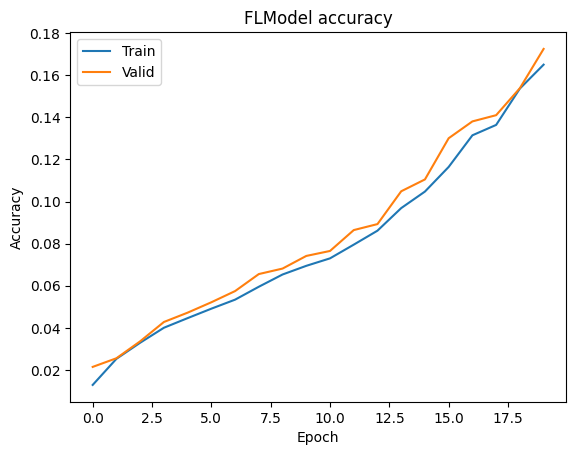

In [8]:
from matplotlib import pyplot as plt

# Draw accuracy values for training & validation
plt.plot(history["global_history"]['multiclassaccuracy'])
plt.plot(history["global_history"]['val_multiclassaccuracy'])
plt.title('FLModel accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()